In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('ZipData_CLEANED.csv')

In [2]:
#remove outliers
y = df['Pop2010']
removed_outliers_pop = y.between(y.quantile(.05), y.quantile(.95))
df = df[df['Pop2010'] != removed_outliers_pop]
print(df['Pop2010'].describe())

count       31.000000
mean     33153.419355
std      15904.292414
min        934.000000
25%      21698.000000
50%      32733.000000
75%      46395.000000
max      69752.000000
Name: Pop2010, dtype: float64


In [3]:
#remove outliers
y = df['AREALAND']
removed_outliers_AREALAND = y.between(y.quantile(.05), y.quantile(.95))
df = df[df['AREALAND'] != removed_outliers_AREALAND]
print(df['AREALAND'].describe())

count    3.100000e+01
mean     1.599995e+07
std      1.074131e+07
min      4.614240e+05
25%      7.306940e+06
50%      1.522794e+07
75%      2.512935e+07
max      4.014365e+07
Name: AREALAND, dtype: float64


In [4]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

[2.48168003e-05 5.79532145e-05]


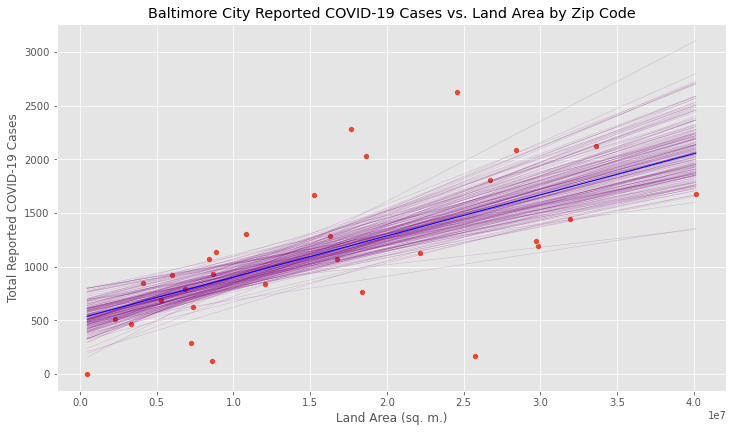

[[1.         0.62012034]
 [0.62012034 1.        ]]


In [8]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(df['AREALAND'].to_numpy(),df['TotalCases'].to_numpy(),200)

#95% C.I. for regression line slopes
cis95 = np.percentile(bs_slope_reps,[2.5,97.5])
print(cis95)

#linear regression with 200 bootstrap lines 
a,b = np.polyfit(df['AREALAND'],df['TotalCases'],1)
x = np.array([df['AREALAND'].min(),df['AREALAND'].max()])
y = a * x + b

_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
for i in range(200):
    _ = plt.plot(x,bs_slope_reps[i]*x + bs_intercept_reps[i],
                linewidth=0.5,alpha=0.2,color='purple')
_ = plt.plot(x,y,linewidth=1, color='blue')
_ = sns.scatterplot(x='AREALAND',y='TotalCases',data=df,legend=False)
_ = plt.xlabel('Land Area (sq. m.)')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Land Area by Zip Code')
plt.show()
corr = np.corrcoef(df[['AREALAND','TotalCases']],rowvar=False)
print(corr)

In [6]:
caseArray = df['TotalCases'].to_numpy()
per33 = np.percentile(caseArray,100/3)
print(per33)
per67 = np.percentile(caseArray,((100/3)*2))
print(per67)

labelList = []

for index, row in df.iterrows():
    if row['TotalCases'] < per33:
        labelList.append('lowCases')
    elif row['TotalCases'] >= per33:
        if row['TotalCases'] < per67:
            labelList.append('medCases')
        elif row['TotalCases'] >= per67:
            labelList.append('highCases')
        
df['classLabel'] = labelList
print(df[['Zip Code','Pop2010','AREALAND','TotalCases','classLabel']])

839.0
1282.0
    Zip Code  Pop2010    AREALAND  TotalCases classLabel
0      21201  16972.0   3340677.0         468   lowCases
1      21202  22832.0   4111039.0         851   medCases
2      21205  16146.0   5304530.0         686   lowCases
3      21206  50846.0  18667230.0        2029  highCases
4      21207  48133.0  26710727.0        1804  highCases
5      21208  33917.0  31925959.0        1443  highCases
6      21209  26465.0  18354471.0         768   lowCases
7      21210  14292.0   8579050.0         120   lowCases
8      21211  17351.0   7219042.0         290   lowCases
9      21212  32322.0  12042941.0         839   medCases
10     21213  32733.0   8833257.0        1140   medCases
11     21214  20564.0   7394837.0         621   lowCases
12     21215  60161.0  17645223.0        2287  highCases
13     21216  32071.0   8634688.0         933   medCases
14     21217  37111.0   5999196.0         921   medCases
15     21218  49796.0  10836080.0        1302  highCases
16     21222  5578

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(df[['Pop2010','AREALAND']],\
                     df['classLabel'],test_size=0.3,\
                         random_state=123,stratify=df['classLabel'])

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)
print('\n\nPredictions:')
print(y_pred)
score = knn.score(X_test,y_test)
print('\n\nAccuracy:')
print(score)
print('\n')



Predictions:
['medCases' 'lowCases' 'medCases' 'lowCases' 'lowCases' 'lowCases'
 'highCases' 'highCases' 'medCases' 'lowCases']


Accuracy:
0.6




In [14]:
print(X_train)
print(y_train)

    Pop2010    AREALAND
13  32071.0   8634688.0
25  15748.0   2259604.0
10  32733.0   8833257.0
3   50846.0  18667230.0
7   14292.0   8579050.0
29  28793.0   8375263.0
9   32322.0  12042941.0
6   26465.0  18354471.0
11  20564.0   7394837.0
24  33568.0  16325575.0
15  49796.0  10836080.0
12  60161.0  17645223.0
23  45213.0  15227940.0
21  33534.0  29853685.0
30    934.0    461424.0
22  47577.0  40143654.0
20   7561.0  25718732.0
8   17351.0   7219042.0
27  38474.0  22187907.0
19  33545.0  16741531.0
16  55786.0  28389988.0
13     medCases
25     lowCases
10     medCases
3     highCases
7      lowCases
29     medCases
9      medCases
6      lowCases
11     lowCases
24    highCases
15    highCases
12    highCases
23    highCases
21     medCases
30     lowCases
22    highCases
20     lowCases
8      lowCases
27     medCases
19     medCases
16    highCases
Name: classLabel, dtype: object
